# Finetune a Langage Model with Fast.ai
Notebook based on:
- https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb
- https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb

Video:
- https://www.youtube.com/watch?v=WjnwWeGjZcM (From 0:00 to 55:00)

#### Get latest Fast.ai version (without installing the Pytorch dependency)

In [1]:
!pip install --upgrade --no-deps fastai
!pip install --upgrade --no-deps fastcore

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.0)
Requirement already up-to-date: fastcore in /usr/local/lib/python3.7/dist-packages (1.3.19)


#### Imports

In [2]:
from fastai.text.all import * # We need fastai version 2 for this
from pathlib import Path

#### Check GPU usage

In [3]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: Not GPU detected")

Using GPU: Tesla K80


# Get data

In [4]:
CLOUD = True

In [5]:
if CLOUD:
    # Download the data from internet
    # If you are using cloud platforms
    # like Google Colab or Kaggle kernels
    data_path = untar_data(URLs.IMDB)
else:
    # Point to the path where the data is
    # located at your local machine
    data_path = Path("../../Datasets/NLP/IMBd")
    
print("Dataset is loacted at:", data_path)

Dataset is loacted at: /root/.fastai/data/imdb


In [6]:
print("Train:", len(list( (data_path/"train").glob('**/*.txt') )), "reviews")
print("Test: ", len(list( (data_path/"test").glob('**/*.txt')  )), "reviews")
print("Unsup:", len(list( (data_path/"unsup").glob('**/*.txt') )), "reviews")

Train: 25000 reviews
Test:  25000 reviews
Unsup: 50000 reviews


# Dataset

In [7]:
files = get_text_files(data_path, folders = ['train', 'test', 'unsup'])
files

(#100000) [Path('/root/.fastai/data/imdb/train/neg/11850_3.txt'),Path('/root/.fastai/data/imdb/train/neg/11981_4.txt'),Path('/root/.fastai/data/imdb/train/neg/7924_1.txt'),Path('/root/.fastai/data/imdb/train/neg/6308_1.txt'),Path('/root/.fastai/data/imdb/train/neg/5460_4.txt'),Path('/root/.fastai/data/imdb/train/neg/284_2.txt'),Path('/root/.fastai/data/imdb/train/neg/11313_3.txt'),Path('/root/.fastai/data/imdb/train/neg/919_1.txt'),Path('/root/.fastai/data/imdb/train/neg/35_3.txt'),Path('/root/.fastai/data/imdb/train/neg/5452_4.txt')...]

In [8]:
txt = files[0].open().read()
txt[:75]

'"Rival reporters Pat Morgan (Ginger Rogers) and Ted Rand (Lyle Talbot) are '

## Dataloader

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

- takes 5 mins for tokenization in Kaggle
- takes 1 mins for tokenization in local machine

In [16]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

imdb_dls_lm = DataBlock(
    blocks    = TextBlock.from_folder(data_path, is_lm=True),
    get_items = get_imdb,
    splitter  = RandomSplitter(0.1)
).dataloaders(data_path, path=data_path, bs=128, seq_len=80)

In [10]:
imdb_dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj oh , that was a really bad film . i like sci - fi very much , but this one … this is not sci - fi , this is a low - budget , low - story , low - acting "" low - film "" . xxmaj during watching the film i was waiting for something good , a good scene , a new idea , or … something . xxmaj unfortunately the end credits came","xxmaj oh , that was a really bad film . i like sci - fi very much , but this one … this is not sci - fi , this is a low - budget , low - story , low - acting "" low - film "" . xxmaj during watching the film i was waiting for something good , a good scene , a new idea , or … something . xxmaj unfortunately the end credits came before"
1,"of course that one important person on the plane , and the hijacker looking for revenge . xxmaj the sad thing is , some of the methods to stop the hijackers have already been used in other movies . xxmaj are we really becoming so unoriginal so quickly ? \n\n xxmaj although it 's ice - t ( who for some incomprehensible reason makes painful attempts at xxup acting while he 's not busy putting the "" c "" back","course that one important person on the plane , and the hijacker looking for revenge . xxmaj the sad thing is , some of the methods to stop the hijackers have already been used in other movies . xxmaj are we really becoming so unoriginal so quickly ? \n\n xxmaj although it 's ice - t ( who for some incomprehensible reason makes painful attempts at xxup acting while he 's not busy putting the "" c "" back in"


In [11]:
print(imdb_dls_lm.vocab[:100])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', '"', "'s", '-', 'was', '\n\n', 'as', 'with', 'for', 'movie', 'but', 'film', 'you', ')', 'on', "n't", '(', 'not', 'are', 'he', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', '!', 'there', 'or', 'just', 'her', 'do', 'about', 'has', 'out', "'", 'if', 'what', 'some', '?', 'good', 'when', 'more', 'very', 'she', 'up', 'would', 'no', '…', 'time', 'even', 'my', 'can', 'their', 'which', 'only', 'story', 'really', 'see', 'had', 'were', 'did', 'me', 'well', 'we', 'does', 'than', 'much', ':', 'could', 'bad', 'get']


In [12]:
len(imdb_dls_lm.vocab)

60008

# Create the Fastai learner (dataloader + model + loss)

In [13]:
learn = language_model_learner(
    dls       = imdb_dls_lm,
    arch      = AWD_LSTM,
    drop_mult = 0.3, 
    metrics   = [accuracy, Perplexity()],
    cbs       = [ShowGraphCallback]
).to_fp16()

### Text Generation BEFORE FINETUNNNG WITH IMDB (Just for fun :D)

In [14]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The 30th Anniversary of Elizabeth 's Final Victory version of the episode , aired on December 29 , 2007 , the episode was broadcast on February 21 , 2007 . An episode of the

The German invasion of the German Empire = The German Empire was a breakaway of the states who had entered the war . The German Empire ( German : "

The Film Festival of New York , Australia , October 21 – 26 , 1998 , Sydney , Australia , New Zealand , Canada , and the United

The Rigsby Siege = = bread The Siege of Affections is a children 's novel by David Lean , written and published in 2010 by Brigham Young University . It

The Cleveland Browns game play - by - play author , Cleveland , Ohio , National Football League Hall of Fame All - Star , and Cleveland Browns


## Fine-Tuning the Language Model with IMDB
- This takes 24:46 mins on GTX 1080ti 11GB
- This takes 27:48 mins on Tesla P100 16GB (Kaggle GPU)
- This takes ~22mins mins on Tesla T4 (Colab GPU)
- This takes >30mins mins on Tesla K80 (Colab GPU)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.034411,3.924759,0.299196,50.640854,2:00:51


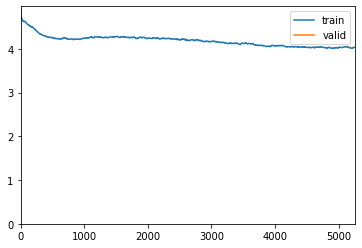

In [17]:
learn.fit_one_cycle(1, 2e-2)

### Saving and Loading Models
You can easily save the state of your model like so:

In [18]:
learn.save('IMDb_LM_1epoch_frozen')

Path('/root/.fastai/data/imdb/models/IMDb_LM_1epoch_frozen.pth')

In [19]:
learn.path

Path('/root/.fastai/data/imdb')

This will create a file in `learn.path/models/` named *IMDb_LM_1epoch_frozen.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [20]:
learn = learn.load('IMDb_LM_1epoch_frozen')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [21]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time


KeyboardInterrupt: ignored

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [22]:
learn.save_encoder('finetuned_IMDb_LM')

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation AFTER FINETUNNNG WITH IMDB (Just for fun :D)
Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [23]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The Wicker Man is a great movie based on THE JULIAN Line with a executed script . It has a very good plot and a fairly bad ending . This movie does n't have

The film was shot in a studio , which was shot in black and white , shot in a studio lens . Half - way through the film it is filmed with black and white camera shots of two and

The first movie of the series is a little bit too predictable . The remake of the original CRUEL ROBIN HOOD is quite a little too long to find . However , the original was daring

The first movie of the movie , Manos , Hands , Notes First , did n't go into theaters . The first movie was " The Slave of the City " , and

The Dalton Brothers play in the works of David Niven and Alec Guinness . 

 The show is very well done in Britain by one reviewer . The lead actor of the


In [24]:
TEXT        = "I liked this movie because"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

i liked this movie because it was very touching and sad , and it was so rare , and i think that all this movie is really a great movie . It 's brilliant and i do n't think it 's really entertaining .

i liked this movie because i gave it a chance at the time . But i just wanted to see it again and it was just going to be a very bad movie ! It is just a huge bore . i think

i liked this movie because it simply was not the best movie i have seen . Well , it was a great movie , so i just got ta see it . i was surprised with the movie .. i thought it was good

i liked this movie because the movie was not only a funny movie , so i watched it . It is a great movie . It was about an English boy who lost his love . His father loved Emma

i liked this movie because the Queen Elizabeth was played by Mary Van Dyke . It was also Elizabeth Taylor who played the daughter of a Englishman . The relationship between Kiera Knightley


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

# <center> END
<center> We have fintuned the Language Model with the IMDb dataset.
<center> The next step is using that model to train a classifier.